In [33]:
import warnings
import os
import numpy as np
import pandas as pd

In [2]:
pip install openpyxl

In [3]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [4]:
pip install pypsa

In [5]:
import pypsa
from pypsa.linopt import get_var, linexpr, define_constraints

In [6]:
import matplotlib.pyplot as plt
import matplotlib

In [7]:
from datetime import timedelta

In [8]:
def fmt_float(x) :
    float_fmt_str = "{:6.2f}"
    return (float_fmt_str.format(x))

pd.set_option('float_format', fmt_float)
idx = pd.IndexSlice

In [9]:
#read in renewables.ninja solar time series
solar_pu_raw = pd.read_csv('../input/ir-dataset/IR-DATASET/ninja_pv_europe_v1.1_sarah.csv',
                           usecols=['time','IE'],
                           index_col='time',
                           parse_dates=True).tz_localize('UTC')

In [10]:
#read in renewables.ninja wind time series
wind_pu_raw = pd.read_csv('../input/ir-dataset/IR-DATASET/ninja_wind_europe_v1.1_current_on-offshore.csv',
                          usecols=['time','IE_ON','IE_OFF'],
                          index_col='time',
                          parse_dates=True).tz_localize('UTC')

In [11]:
forecast=pd.read_csv('../input/irforecastload2030/forecast_2030.csv',parse_dates=True, index_col='ds')

In [12]:
forecast=forecast.resample('H').mean()

In [13]:
elec_load=forecast.copy()
elec_load_truncated=elec_load.truncate(before="01-01-2023",after="01-01-2030")
#This is a leap year so must remove the extra day
elec_load_truncated= elec_load_truncated[~((elec_load_truncated.index.month == 2) & (elec_load_truncated.index.day == 29))] 
elec_load_truncated= elec_load_truncated[~((elec_load_truncated.index.month == 2) & (elec_load_truncated.index.day == 29))] 

In [14]:
elec_load_truncated=elec_load_truncated.iloc[:-1,:]

In [15]:
load_profile=elec_load_truncated[['yhat']]
load_profile_array=load_profile['yhat'].values

In [16]:
load_profile_array

In [17]:
wind_pu_raw=wind_pu_raw.truncate(before="01-01-2008",after="01-01-2015")

In [18]:
wind_pu_raw= wind_pu_raw[~((wind_pu_raw.index.month == 2) & (wind_pu_raw.index.day == 29))] 
wind_pu_raw=wind_pu_raw.iloc[:-1,:]

In [19]:
solar_pu_raw=solar_pu_raw.truncate(before="01-01-2008",after="01-01-2015")
solar_pu_raw= solar_pu_raw[~((solar_pu_raw.index.month == 2) & (solar_pu_raw.index.day == 29))] 
solar_pu_raw=solar_pu_raw.iloc[:-1,:]

In [20]:
solar_pu_raw

In [21]:
Inst_max_solar_power=solar_pu_raw['IE']

In [22]:
Inst_max_wind_power_on=wind_pu_raw['IE_ON']
Inst_max_wind_power_off=wind_pu_raw['IE_OFF']

In [23]:
Inst_max_solar_power

In [24]:
assumptions_raw=pd.read_excel('../input/assumption/SWIS.xlsx',usecols=['technology','year','parameter','value','unit'],
                                index_col=list(range(3)),
                                header=0).sort_index()


In [25]:
assumptions_raw.loc['Natural Gas-CCGT',:]

In [26]:
def annuity(lifetime, rate):
    if rate == 0.0 :
        return 1.0/lifetime
    else:
        return rate/(1.0 - (1.0 / (1.0 + rate)**lifetime))

def prepare_assumptions(Nyears=1,usd_to_eur=0.99,assumptions_year=2030):
    """set all asset assumptions and other parameters for specific run_config"""

    assumptions = assumptions_raw.copy(deep=True)

    #correct units to MW, EUR, tCO2
    assumptions.loc[assumptions.unit.str.contains("/kgCO2"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("/kW"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("/KW"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("USD"),"value"]*=usd_to_eur

    assumptions = assumptions.loc[idx[:,assumptions_year,:],
                                  "value"].unstack(level=2).groupby(level="technology").sum(min_count=1)

    #fill defaults
    assumptions = assumptions.fillna({"FOM" : assumptions.at["default","FOM"],
                                      "discount rate" : assumptions.at["default","discount rate"],
                                      "lifetime" : assumptions.at["default","lifetime"]})

    #annualise investment costs, add FOM
    # (FOM = estimated "Follow On Maintenance", as % of initial capex, per annum?)
    assumptions["fixed"] = [(annuity(v["lifetime"],v["discount rate"]) + 
                             v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions.iterrows()]

    return assumptions


In [27]:
assumptions=prepare_assumptions(Nyears=7)

In [28]:
assumptions

# Section 2: Build a PYPSA grid network constrained with Maximum C02 emissions

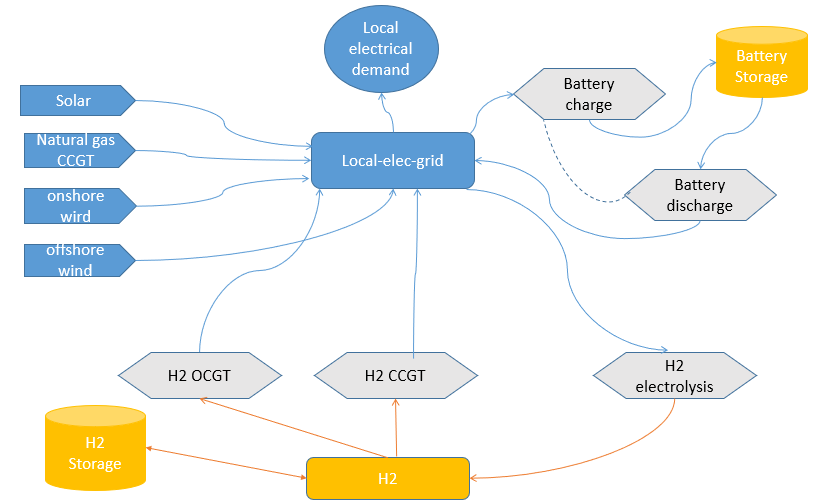

In [29]:
snap_df=pd.DataFrame()
snap_df['Date']=pd.date_range(start="01-01-2023",end="01-01-2030",freq='H',
                         tz='UTC')
snap_df=snap_df.set_index('Date')

In [30]:
snap_df= snap_df[~((snap_df.index.month == 2) & (snap_df.index.day == 29))] 

In [31]:
snap_index=snap_df.index[:-1]

In [32]:
conda install coin-or-cbc

### Maximum allowable Natural Gas CCGT as per CO2 constraint

In [34]:
#as per Current and prospective costs of electricity generation until 2050 : 
#CO2 Emissions from new combined cycle natural gas plant is 0.33 T/MWh #availabe at : https://www.econstor.eu/handle/10419/80348
# 3MTC02eq is the maximum C02 emission from electricity sector for year 2030. 
# Calculate the maximum MWH Generated per year that can be generated from natural gas resources to be used as constraint.
maximum_MWH_Natural_Gas=((3*1e6) / (0.33))*7
#maximum_capacity_natural_Gas=maximum_MWH_Natural_Gas /(8760*1000) #GW 
print("Maximum Allowable MWH natural Gas CCGT dispatch is ",round(maximum_MWH_Natural_Gas,2),"MWH")

In [35]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]

In [36]:
network = pypsa.Network(override_component_attrs=override_component_attrs)

In [37]:
snapshot_interval=1
solver_name=bool('cbc')
#check snapshots
snapshots=snap_index
network.set_snapshots(snapshots)
network.set_snapshots_weightings=pd.Series(float(snapshot_interval),index=network.snapshots)    

In [38]:
network.add("Bus","local-elec-grid")
network.add("Load","local-elec-demand",
                bus="local-elec-grid",
                p_set= load_profile_array)
network.add("Generator","Natural Gas-CCGT",
                bus="local-elec-grid",
                p_nom_extendable = True,
                p_nom_min = 0,
                #p_nom_max = 5.7 *1e3 , #MW
                p_nom_max=+np.inf,# it will be constrained by maximum MWH Natural gas.      
                # Margnial cost based on assumption $8.1/MMBtu of Gas and  conversion efficency of 0.57
                marginal_cost = 52.7 ,  #Euro/MWH
                capital_cost = assumptions.at['Natural Gas-CCGT','fixed'],
               )
network.add("Generator","solar",
                bus="local-elec-grid",
                p_max_pu = Inst_max_solar_power.values,
                p_nom_extendable = True,
                p_nom_min = 0.77 *1e3 ,#MW                                                    
                p_nom_max = +np.inf ,#mW ximum planned nominal capacity at 2030 
                marginal_cost = 0.03,#€/MWh
                #Small cost to prefer curtailment to destroying energy in storage
                capital_cost = assumptions.at['utility solar PV','fixed'],
            )
network.add("Generator","onshore wind",
                bus="local-elec-grid",
                p_max_pu = Inst_max_wind_power_on.values ,
                    # Hardwired choice of IE location for renewables.ninja
                    # "_ON" codes for "onshore" in renewables.ninja wind data
                p_nom_extendable = True,
                p_nom_min = 0,#GW 
                p_nom_max = +np.inf ,#MW year 2030 ambition
                marginal_cost = 0.02,
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['onshore wind','fixed'])

network.add("Generator","offshore wind",
                bus="local-elec-grid",
                p_max_pu = Inst_max_wind_power_off.values ,
                    # Hardwired choice of IE location for renewables.ninja
                    # "_OFF" codes for "onshore" in renewables.ninja wind data
                p_nom_extendable = True,
                p_nom_min = 0, #GW
                p_nom_max = +np.inf ,#MW
                marginal_cost = 0.01,
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['offshore wind','fixed'])
network.add("Bus","battery")

network.add("Store","battery storage",
                bus = "battery",
                e_nom_extendable = True,
                e_nom_max = +np.inf,#The excess power will be stored there 
                e_cyclic=True,
                capital_cost=assumptions.at['battery storage','fixed'])
network.add("Bus", "H2",
                     carrier="H2")

h2_electrolysis_tech = 'H2 electrolysis default'

network.add("Link", "H2 electrolysis",
                bus0="local-elec-grid", # input
                bus1="H2", # output
                p_nom_extendable=True,
                p_nom_max = +np.inf , #MW
                efficiency=assumptions.at["H2 electrolysis","efficiency"],
                capital_cost=assumptions.at[h2_electrolysis_tech,"fixed"])

network.add("Link", "H2 CCGT",
                bus0="H2",
                bus1="local-elec-grid",
                p_nom_extendable=True,
                p_nom_max = +np.inf,#MW >> already bounded with Grid capacity 
                efficiency=assumptions.at["H2 CCGT","efficiency"],
                capital_cost=assumptions.at["H2 CCGT","fixed"]*assumptions.at["H2 CCGT","efficiency"])  
                #NB: fixed (capital) cost for H2 CCGT in assumptions is per MWel (p1 of link)

network.add("Link", "H2 OCGT",
                bus0="H2",
                bus1="local-elec-grid",
                p_nom_extendable=True,
                p_nom_max = +np.inf,# already bounded with Generated H2 from electrolysis
                efficiency=assumptions.at["H2 OCGT","efficiency"],
                capital_cost=assumptions.at["H2 OCGT","fixed"]*assumptions.at["H2 OCGT","efficiency"])  
                
network.add("Link","battery charge",
                bus0 = "local-elec-grid",
                bus1 = "battery",
                efficiency = assumptions.at['battery inverter','efficiency'],
                p_nom_extendable = True,
                p_nom_max = +np.inf,
                capital_cost=assumptions.at['battery inverter','fixed'])

network.add("Link","battery discharge",
                bus0 = "battery",
                bus1 = "local-elec-grid",
                efficiency = assumptions.at['battery inverter','efficiency'],
                p_nom_extendable = True,
                capital_cost=0.0
           )

h2_storage_tech = 'H2 ' + 'salt cavern' + ' storage'                                               

network.add("Store", "H2 store",
                bus="H2",
                e_nom_extendable=True,
                e_nom_max = +np.inf,#TWH >> Already bounded with Grid capacity 
                # TWh -> MWh
                e_cyclic=True,
                capital_cost=assumptions.at[h2_storage_tech,"fixed"])

In [39]:
def extra_functionality(network,snapshots):
    link_p_nom = get_var(network, "Link", "p_nom")
       
    lhs = linexpr((1.0,link_p_nom["battery charge"]),
                      (-network.links.loc["battery discharge", "efficiency"],
                       link_p_nom["battery discharge"]))
    
    define_constraints(network, lhs, "=", 0.0, 'Link', 'battery_charger_ratio')
    generator_p_nom=get_var(network, 'Generator', 'p')
    lhs_gen = linexpr((1,generator_p_nom["Natural Gas-CCGT"])).sum()                                             
                                               #maximum_MWH_Natural_Gas
    define_constraints(network, lhs_gen, "<=", maximum_MWH_Natural_Gas, 'Generator', 'max_constraint')
solver_options = {}
network.consistency_check()   
network.lopf(solver_name='cbc',
                  solver_options=solver_options,
                  pyomo=False,
                  extra_functionality=extra_functionality)   

In [40]:
def gather_run_stats(network):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logger.info("NB - RuntimeWarning(s) suppressed (if any)...")

        run_stats = pd.Series()
    
        total_hours = network.snapshot_weightings.sum()


        network.loads['e'] = (network.loads_t.p.sum() * snapshot_interval)

        network.generators['e_avail'] = (
            network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).sum() 
            * snapshot_interval)
        network.generators['e_dispatched'] = network.generators_t.p.sum() * snapshot_interval

        # network.generators_t.p_max_pu is not returned by lopf()
        # for gens with static p_max_pu (since it doesn't change
        # in time) but we want to do various generic calculations
        # for *all* generators using this so add it in for such
        # generators, if any...
        for g in network.generators.index :
            if (not(g in network.generators_t.p_max_pu.columns)) :
                network.generators_t.p_max_pu[g] = network.generators.at[g,'p_max_pu']

        # We want timeseries of link power gain/loss for potential use in power balance plots
        links_net_p = -(network.links_t.p0 + network.links_t.p1)
        network.links_t['p_gain'] = links_net_p.clip(lower=0.0)
            # +ve => Gain/tacit Generator (typically environmental heat via HP)
        network.links_t['p_loss'] = links_net_p.clip(upper=0.0)
            # -ve -> Loss/tacit Load

    
        network.links_t['p_load'] = pd.DataFrame(0.0,
                                    columns=network.links_t.p0.columns,
                                    index=network.links_t.p0.index)      
        network.links['e0'] = network.links_t.p0.sum() * snapshot_interval
        network.links['e1'] = network.links_t.p1.sum() * snapshot_interval
        network.links['e_gain'] = network.links_t.p_gain.sum() * snapshot_interval
        network.links['e_loss'] = network.links_t.p_loss.sum() * snapshot_interval
        network.links['e_load'] = network.links_t.p_load.sum() * snapshot_interval
        
        
        total_load_p = network.loads_t.p.sum(axis='columns') + network.links_t.p_load.sum(axis='columns')
        max_load_p = total_load_p.max()
        mean_load_p = total_load_p.mean()
        min_load_p = total_load_p.min()

        total_e_load = network.loads['e'].sum() + network.links['e_load'].sum()
        total_e_available = network.generators['e_avail'].sum()
        total_e_dispatched =  network.generators['e_dispatched'].sum()
        total_generated_e = total_e_dispatched + network.links['e_gain'].sum()
        total_losses_e = -network.links['e_loss'].sum()
        total_consumed_e = total_e_load + total_losses_e
        assert((total_generated_e - total_consumed_e) < 1.0) # Notional tolerance on system balance, MWh
        total_e_undispatched = total_e_available - total_e_dispatched 

        run_stats["System total load (TWh)"] = total_e_load/1.0e6
        run_stats["System mean load (GW)"] = mean_load_p/1.0e3

        run_stats["System available primary (TWh)"] = total_e_available/1.0e6
        run_stats["System dispatched (TWh)"] = total_e_dispatched/1.0e6
        run_stats["System dispatched down (TWh)"] = total_e_undispatched/1.0e6
        run_stats["System dispatched down (%)"] = (total_e_undispatched/total_e_available)*100.0

        run_stats["System generated (TWh)"] = total_generated_e/1.0e6 # Includes "link gains" (essentially HP?)
        run_stats["System losses (TWh)"] = total_losses_e/1.0e6
        run_stats["System efficiency (%)"] = (total_e_load/total_generated_e)*100.0

        for l in network.loads.index :
            total_e = network.loads.at[l,'e']
            run_stats[l+" total_e (TWh)"] = (total_e/1.0e6)
            run_stats[l+" max_p (GW)"] = network.loads_t.p[l].max()/1.0e3
            run_stats[l+" mean_p (GW)"] = (total_e/(total_hours*1.0e3))
            run_stats[l+" min_p (GW)"] = network.loads_t.p[l].min()/1.0e3

        for g in network.generators.index :
    
            e_avail = network.generators.at[g,'e_avail']
            e_dispatched = network.generators.at[g,'e_dispatched']
            e_undispatched = e_avail - e_dispatched
            run_stats[g+" capacity nom (GW)"] = (
                network.generators.p_nom_opt[g]/1.0e3)
            run_stats[g+" available (TWh)"] = e_avail/1.0e6
            run_stats[g+" dispatched (TWh)"] = e_dispatched/1.0e6
            run_stats[g+" penetration (%)"] = (e_dispatched/total_e_dispatched)*100.0 
            run_stats[g+" dispatched down (TWh)"] = e_undispatched/1.0e6
            run_stats[g+" dispatched down (%)"] = (e_undispatched/e_avail)*100.0
            run_stats[g+" capacity factor max (%)"] = (
                network.generators_t.p_max_pu[g].mean())*100.0
            run_stats[g+" capacity factor act (%)"] = (
                e_dispatched/(network.generators.p_nom_opt[g]*total_hours))*100.0

        # Battery "expected" to be "relatively" small so we represent stats as MW (power) or MWh (energy)
        battery_charge_p = network.links.p_nom_opt["battery charge"]
        run_stats["Battery charge/discharge capacity nom (MW)"] = battery_charge_p
            # NB: battery charge and discharge p_nom are constrained to be equal (grid side)
        battery_total_e = (network.links.at["battery charge","e0"] +
                           (-network.links.at["battery discharge","e1"])) # on grid side
        run_stats["Battery transferred (GWh)"] = battery_total_e/1.0e3
        run_stats["Battery capacity factor (%)"] = (battery_total_e/(
            network.links.p_nom_opt["battery charge"]*total_hours))*100.0
        battery_store_e = network.stores.e_nom_opt["battery storage"]
        run_stats["Battery store (MWh)"] = battery_store_e
        battery_discharge_p = network.links.p_nom_opt["battery discharge"]
        battery_store_h = battery_store_e/battery_discharge_p
        run_stats["Battery store time (h)"] = battery_store_h
        #run_stats["Battery storage time (d)"] = battery_store_h/24.0
        
       
        links_H2 = ["H2 electrolysis", "H2 OCGT", "H2 CCGT"]
        for l in links_H2:
            run_stats[l+" i/p capacity nom (GW)"] = (network.links.p_nom_opt[l]/1.0e3)
            run_stats[l+" o/p capacity nom (GW)"] = (
                (network.links.p_nom_opt[l]*network.links.efficiency[l])/1.0e3)
            run_stats[l+" capacity factor (%)"] = (
                network.links.at[l,'e0']/(network.links.p_nom_opt[l]*total_hours))*100.0

        p2h2p_total_e = (network.links.at["H2 electrolysis","e0"] +
                         (-(network.links.at["H2 OCGT","e1"]
                            + network.links.at["H2 CCGT","e1"]))) 
                        # OCGT, CCGT both on grid side (e1)
        run_stats["P2H2P transferred (TWh)"] = p2h2p_total_e/1.0e6    
        h2_store_e = network.stores.e_nom_opt["H2 store"]
        run_stats["H2 store (TWh)"] = (h2_store_e/1.0e6)
        h2_store_CCGT_p = network.links.p_nom_opt["H2 CCGT"]
        h2_store_CCGT_h = h2_store_e/h2_store_CCGT_p
        run_stats["H2 store time (CCGT, h)"] = h2_store_CCGT_h 
        run_stats["H2 store time (CCGT, d)"] = h2_store_CCGT_h/24.0
        h2_store_OCGT_p = network.links.p_nom_opt["H2 OCGT"]
        h2_store_OCGT_h = h2_store_e/h2_store_OCGT_p
        run_stats["H2 store time (OCGT, h)"] = h2_store_OCGT_h 
        run_stats["H2 store time (OCGT, d)"] = h2_store_OCGT_h/24.0

        run_stats["System total raw store I+B+H2 (TWh)"] = (
            h2_store_e+battery_store_e)/1.0e6

        # calculation of how much electricity can be generated
        # from the available storage, based on the efficiencies of the respective
        # conversion paths.
        if (h2_store_CCGT_p > 0.01*mean_load_p) :
            h2_store_gen_efficiency = network.links.at["H2 CCGT","efficiency"]
        else :
            h2_store_gen_efficiency = network.links.at["H2 OCGT","efficiency"]
        total_avail_store_gen = ((h2_store_e*h2_store_gen_efficiency) +
                        (battery_store_e*network.links.at["battery discharge","efficiency"]))

        run_stats["System total usable store I+H2 (TWh)"] = total_avail_store_gen/1.0e6
        total_avail_store_gen_h = total_avail_store_gen/mean_load_p
        run_stats["System total usable store/load (%) "] = (total_avail_store_gen/total_e_load)*100.0
        run_stats["System total usable store time (h)"] = total_avail_store_gen_h
        run_stats["System total usable store time (d)"] = total_avail_store_gen_h/24.0

        run_stats["System notional cost (B€)"] = network.objective/1.0e9 
        run_stats["System notional LCOE (€/MWh)"] = network.objective/total_e_load

        buses = ["local-elec-grid", "H2"]
        for b in buses:
            run_stats[b+" max notional shadow price (€/MWh)"] = (
                network.buses_t.marginal_price[b].max())
            run_stats[b+" mean notional shadow price price (€/MWh)"] = (
                network.buses_t.marginal_price[b].mean())
            run_stats[b+" min notional shadow price (€/MWh)"] = (
                network.buses_t.marginal_price[b].min())

                    # All the following are "weighted means": shadow prices at a bus weighted by some flow to or from that bus 

        run_stats["Elec. load weighted mean notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.loads_t.p["local-elec-demand"]).sum())
                                  / network.loads_t.p["local-elec-demand"].sum())

 
        
        run_stats["Offshore wind notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.generators_t.p["offshore wind"]).sum())
                                  / network.generators_t.p["offshore wind"].sum())

        run_stats["Onshore wind notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.generators_t.p["onshore wind"]).sum())
                                  / network.generators_t.p["onshore wind"].sum())

        run_stats["Solar notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.generators_t.p["solar"]).sum())
                                  / network.generators_t.p["solar"].sum())
        
        run_stats["Natural Gas -CCGT notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.generators_t.p["Natural Gas-CCGT"]).sum())  
                                  / network.generators_t.p["Natural Gas-CCGT"].sum())

        run_stats["Battery charge notional shadow price (€/MWh)"] = ( 
            ((network.buses_t.marginal_price["local-elec-grid"]*network.links_t.p0["battery charge"]).sum())
                                  / network.links_t.p0["battery charge"].sum())

        run_stats["Battery discharge notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.links_t.p1["battery discharge"]).sum())
                                  / network.links_t.p1["battery discharge"].sum())

        run_stats["H2 for CCGT notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["H2"]*network.links_t.p0["H2 CCGT"]).sum())
                                  / network.links_t.p0["H2 CCGT"].sum())

        run_stats["Elec. from H2 CCGT notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.links_t.p1["H2 CCGT"]).sum())
                                  / network.links_t.p1["H2 CCGT"].sum())

        run_stats["H2 for OCGT notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["H2"]*network.links_t.p0["H2 OCGT"]).sum())
                                  / network.links_t.p0["H2 OCGT"].sum())

        run_stats["Elec. from H2 OCGT notional shadow price (€/MWh)"] = (
            ((network.buses_t.marginal_price["local-elec-grid"]*network.links_t.p1["H2 OCGT"]).sum())
                                  / network.links_t.p1["H2 OCGT"].sum())

    return run_stats

In [41]:
import logging
logging.basicConfig(level=logging.INFO)
logger=logging.getLogger()
run_stats=gather_run_stats(network)
with pd.option_context('display.max_rows', None): 
    display(run_stats)

In [42]:
#compute natural gas emissions
Natural_gas_MWH=run_stats['Natural Gas-CCGT dispatched (TWh)']*1e6
CO2_Emissions_MT=(Natural_gas_MWH*0.33) /1e6 #0.33 T/MWH emissions of natural gas CCGT as per the assumptions
print(" C02 Emissions are ",CO2_Emissions_MT,"Mt")

In [43]:
print(" cost of system at C02 Constraint optimization scenario is ",run_stats['System notional LCOE (€/MWh)'],"€/MWh")

In [44]:
#save run stats
run_stats.to_frame().to_csv('states at CO2 opimization scenario.csv')

#  Plots 
(2011) SWIS 100 [Source repo]. https://github.com/bmcmullin/SWIS-100-IE

In [45]:
Nyears = 7

plt_start = "2023-01-01"
plt_stop = "2030-01-01"

In [46]:
colors = {
    'H2 CCGT' : 'red',
    'H2 OCGT' : 'pink',
    'H2 electrolysis' : 'magenta',
    'H2 store' : 'green',
    'H2 store to bus' : 'green',
    'H2 store from bus' : 'green',
    'Links p_gain ' : 'yellow',
    'Links p_loss' : 'yellow',
    'Storage charge' : 'green',
    'Storage discharge' : 'green',
    'battery charge' : 'gray',
    'battery discharge' : 'gray',
    'battery storage' : 'gray',
    'local-elec-demand' : 'black', 
    'offshore wind' : 'cornflowerblue',
    'onshore wind' : 'royalblue', 
    'solar' : 'brown',
    'Natural Gas-CCGT':'aqua',
    'Links p_load ':'yellow'
}

In [47]:

store_p = network.stores_t.p
# Calculate instantaneous aggregate flow in/out of storage (charge/discharge)
store_flow = store_p.sum(axis='columns')
#display(store_flow)
store_discharge = store_flow.clip(lower=0.0).rename('Storage discharge')
#display(store_discharge)
store_charge = store_flow.clip(upper=0.0).rename('Storage charge')
#display(store_charge)

links_p_gain = network.links_t.p_gain.sum(axis='columns').rename('Links p_gain ')
#display(links_p_gain)
links_p_loss = network.links_t.p_loss.sum(axis='columns').rename('Links p_loss')
#display(links_p_loss)
links_p_load = network.links_t.p_load.sum(axis='columns').rename('Links p_load ') 
#display(links_p_load)

positive = pd.concat(
    [network.generators_t.p, links_p_gain, store_discharge],
    axis='columns').round(10) # pd.DataFrame
#display(positive)   

negative = pd.concat(
    [-network.loads_t.p, -links_p_load, links_p_loss, store_charge],
    axis='columns').round(10) # pd.DataFrame
#display(negative)

In [48]:
# System *must* now "balance"
balance = positive.sum(axis=1) + negative.sum(axis=1) # MW
#display(balance)
#display(balance.max())
#display(balance.min())

assert(abs(balance<0.1).all()) # MW

In [49]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (9,5)

fig, ax = plt.subplots()

positive_max=positive.sum(axis=1).max()
negative_min=negative.sum(axis=1).min()



positive.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                            ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in positive.columns])

negative.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                           ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in negative.columns])

#ax.set_ylim(1.2*demand_max, 2.0*gen_max)
#ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("System balance (inflow is +ve, outflow/loss is -ve) [MW]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()
fig.savefig("./{}.png".format("Scenario CO2 Constraint-Generation and load"),dpi=100)


In [50]:
gens = ["Natural Gas-CCGT", "onshore wind", "offshore wind", "solar"]
loads = ["local-elec-demand"]
in_links = [ "H2 CCGT", "H2 OCGT","battery discharge"]
out_links = [ "battery charge", "H2 electrolysis"]

positive = pd.concat((network.generators_t.p[gens],
                      -network.links_t.p1[in_links]),
                     axis=1).round(10)
negative = pd.concat((-network.loads_t.p[loads],
                      -network.links_t.p0[out_links]),
                     axis=1).round(10)

In [51]:
# bus must balance instantaneously
balance = positive.sum(axis=1) + negative.sum(axis=1)

assert(abs(balance<0.1).all()) # MW

In [52]:
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams["figure.figsize"]=(9,5)

fig, ax = plt.subplots()

positive_max=positive.sum(axis='columns').max() # pd.Dataframe
negative_min=negative.sum(axis='columns').min() # pd.Dataframe

# Set y_lim top extra large (*2.5) to make space for the legend...
positive.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                            ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in positive.columns])

negative.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                           ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in negative.columns])

ax.set_ylabel("Dispatch (generation is +ve, demand is -ve) [MW]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()
fig.savefig("./{}.png".format("load flow at Scenario C02 Constraint"),dpi=100)

In [53]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, ax = plt.subplots()

storage = network.stores_t.e[["H2 store",
                              "battery storage"]].round(10)
#display(storage)

storage.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=1,
                              color=[colors[i] for i in storage.columns])

e_max = storage.sum(axis=1).max()
e_min = storage.sum(axis=1).min()

#ax.set_ylim([demand_max,gen_max])
#print([demand_max,gen_max])
ax.set_ylim([0.0, 1.2*e_max])
ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("Storage [MWh]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()

fig.savefig("./{}.png".format("Scenario CO2 Constraint - storage"),dpi=100)

In [54]:
store_flow = network.stores_t.p["H2 store"]
#display(store_flow)
store_flow_to_bus = store_flow.clip(lower=0.0).rename("H2 store to bus")
#display(store_flow_to_bus)
store_flow_from_bus = store_flow.clip(upper=0.0).rename("H2 store from bus")
#display(store_flow_from_bus)

positive = pd.concat(
    [-network.links_t.p1["H2 electrolysis"].round(10),
    store_flow_to_bus.round(10)],axis='columns') # pd.DataFrame
#display(positive)   

negative = pd.concat(
    [-network.links_t.p0[[ "H2 CCGT", "H2 OCGT"]].round(10),
    store_flow_from_bus.round(1)],axis='columns') # pd.DataFrame
#display(negative)

In [55]:
# bus must balance instantaneously
balance = positive.sum(axis=1) + negative.sum(axis=1)
#display(balance)
#display(balance.max())
#display(balance.min())

assert(abs(balance<0.1).all()) # MW

In [56]:
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams["figure.figsize"] = (8,4)

fig, ax = plt.subplots()


positive_max=positive.sum(axis='columns').max() # pd.Dataframe
negative_min=negative.sum(axis='columns').min() # pd.Series

positive.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                            ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in positive.columns])

negative.loc[plt_start:plt_stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                           ylim=(1.2*negative_min, 2.5*positive_max),
                            color=[colors[i] for i in negative.columns])

ax.set_ylabel("Low temperature heat [MW]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()
fig.savefig("./{}.png".format("H2 Balance at  C02 Constraint Scenario "),dpi=100)

## capacity analysis


In [57]:
output_CO2_Constraint=run_stats.to_frame('stats').reset_index()
output_CO2_Constraint.columns=['state','value']

In [58]:
#filter by capacities
capacity=output_CO2_Constraint[output_CO2_Constraint['state'].str.contains(r'capacity nom')]
print(capacity)
#choose the overall capacity
capacity=capacity[~capacity['state'].str.contains(r'o/p')]
#Normalize the capacity unit to be GW 
capacity.at[45,'value']=capacity.at[45,'value']/1000
#cleaning 
capacity['state']=capacity['state'].apply(lambda x:x[:-4])

In [59]:
capacity

In [60]:
import plotly.express as px

fig = px.bar(capacity.sort_values(by=['value']), x='state', y='value',
             title='C02 Constraint Scenario-Generators capacities in GW ',
             labels={'state':'Generator type' , 'value':'GW'},height=800)
fig.show()